# Artificial Neural Networks and Deep Learning

---

## Homework 1


### 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


### ⚙️ Import Libraries

In [ ]:
%%writefile requirements.txt
tensorflow==2.17.0
keras==3.4.1

Overwriting requirements.txt


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 227.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 kB 22.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
  

In [ ]:
# Set seed for reproducibility
seed = 36

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

import tensorflow as tf
#from tensorflow import keras as tfk
import keras as tfk       #notice how I'm importing keras and not tensorflow.keras
from keras.layers import Input, Dense, Dropout, Lambda
#from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl


print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
#from tensorflow.keras.mixed_precision import experimental as mixed_precision

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Tensorflow version -> 2.17.0
Keras version -> 3.4.1
2.17.0


### ⏳ Load the Data

In [ ]:
data = np.load('training_set.npz')
X = data['images']
y = data['labels'] # Load the training data here
print(y.shape)

(13759, 1)


In [ ]:
# Delete duplicates
X, indices = np.unique(X, return_index=True, axis=0)
y = y[indices]
print(X.shape)
print(y.shape)

(11953, 96, 96, 3)
(11953, 1)


In [ ]:
# intruso_idx and intruso2_idx are the indices of the outliers
intruso_idx = 1008
intruso2_idx = 58

X = np.delete(X, intruso_idx, axis=0)
y = np.delete(y, intruso_idx, axis=0)

X = np.delete(X, intruso2_idx, axis=0)
y = np.delete(y, intruso2_idx, axis=0)

print(f"Nuova shape di X: {X.shape}")
print(f"Nuova shape di y: {y.shape}")

Nuova shape di X: (11951, 96, 96, 3)
Nuova shape di y: (11951, 1)


*italicised text*### Split in train, validation and test set

In [ ]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=y)

y_train_val = np.squeeze(y_train_val)  # Remove the extra dimension

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=y_train_val)



### Data augmentation

In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 24.9 MB/s eta 0:00:00


In [ ]:
print("Valori minimi e massimi dei pixel in X_train_val:")
print(X_train.min(), X_train.max())

Valori minimi e massimi dei pixel in X_train_val:
0 255


In [ ]:
import keras_cv

# Configure AugMix parameters
augmenter = keras_cv.layers.AugMix(
    value_range=(0, 255),
    severity=0.25,
    alpha=1.0
)

# Count class occurrencies
unique_classes, class_counts = np.unique(y_train, return_counts=True)
max_count = max(class_counts) # Find the maximum of the occurrencies

# Perform augmentation on the less represented classes
augmented_images = []
augmented_labels = []

for class_index, count in zip(unique_classes, class_counts):
    class_images = X_train[y_train.flatten() == class_index]
    num_to_augment = max_count - count  # Compute the number of images to be augmented

    # Generate augmented images
    for _ in range(num_to_augment):
        random_image = class_images[np.random.randint(0, len(class_images))]
        augmented_image = augmenter(random_image)
        augmented_images.append(augmented_image)
        augmented_labels.append(class_index)

# Add the augmented images to the train dataset
X_augmented = np.concatenate([X_train, np.array(augmented_images)], axis=0)
y_augmented = np.concatenate([y_train, np.array(augmented_labels)], axis=0)

# Count class occurrencies
classes, counts = np.unique(y_augmented.flatten(), return_counts=True)

for cls, count in zip(classes, counts):
    print(f"Classe {cls}: {count} occorrenze")

print("Nuovo dataset: ", X_augmented.shape, y_augmented.shape)

Classe 0: 1864 occorrenze
Classe 1: 1864 occorrenze
Classe 2: 1864 occorrenze
Classe 3: 1864 occorrenze
Classe 4: 1864 occorrenze
Classe 5: 1864 occorrenze
Classe 6: 1864 occorrenze
Classe 7: 1864 occorrenze
Nuovo dataset:  (14912, 96, 96, 3) (14912,)


In [ ]:
import keras_cv
import numpy as np

# Configure RandAugment parameters
global_augmenter = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=4,
    magnitude=0.2,
)

X_global_augmented = []
y_global_augmented = []

for image, label in zip(X_augmented, y_augmented) :
    # Add the original image to the new training dataset
    X_global_augmented.append(image)
    y_global_augmented.append(label)

    # Generate the aumgented image
    augmented_image = global_augmenter(image)
    X_global_augmented.append(augmented_image)  # Aggiungi l'immagine augmentata
    y_global_augmented.append(label)  # Copia il label corrispondente

# Convert to numpy array
X_global_augmented = np.array(X_global_augmented)
y_global_augmented = np.array(y_global_augmented)

# Count class occurrencies
classes, counts = np.unique(y_global_augmented.flatten(), return_counts=True)

for cls, count in zip(classes, counts):
    print(f"Classe {cls}: {count} occorrenze")

print("Nuova shape di X_global_augmented:", X_global_augmented.shape)
print("Nuova shape di y_global_augmented:", y_global_augmented.shape)

Classe 0: 3728 occorrenze
Classe 1: 3728 occorrenze
Classe 2: 3728 occorrenze
Classe 3: 3728 occorrenze
Classe 4: 3728 occorrenze
Classe 5: 3728 occorrenze
Classe 6: 3728 occorrenze
Classe 7: 3728 occorrenze
Nuova shape di X_global_augmented: (29824, 96, 96, 3)
Nuova shape di y_global_augmented: (29824,)


### Split train_valid into train and validation

In [ ]:
# Convert y to one-hot encoding

y_val = tfk.utils.to_categorical(y_val, num_classes=8)
y_test = tfk.utils.to_categorical(y_test, num_classes=8)
y_global_augmented = tfk.utils.to_categorical(y_global_augmented, num_classes=8) # Reshape to (n_samples,)
print("y_global_augmented shape:", y_global_augmented.shape)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

y_global_augmented shape: (29824, 8)
X_train shape: (9559, 96, 96, 3), y_train shape: (9559,)
X_val shape: (1196, 96, 96, 3), y_val shape: (1196, 8)
X_test shape: (1196, 96, 96, 3), y_test shape: (1196, 8)


### 🛠️ Build the Model

In [ ]:
# Initialise MobileNetV3Large model with pretrained weights, for transfer learning
mobilenet = tfk.applications.MobileNetV3Large(
    input_shape=(96, 96, 3),
    include_top=False, # This indicates that we're excluding the final classification layers of the pre-trained model
    weights='imagenet',
    include_preprocessing=True # This ensures that the necessary preprocessing steps that were applied during the model's original training are also applied to our input images
)

# Display a summary of the model architecture
mobilenet.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(mobilenet, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 96, 96, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 48, 48, 16)     │            432 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 48, 48, 16)     │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 48, 48, 16)     │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 48, 48, 16)     │            144 │ activation[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 48, 48, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 48, 48, 16)     │            256 │ re_lu[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 48, 48, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 48, 48, 16)     │              0 │ activation[0][0],      │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 48, 48, 64)     │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 48, 48, 64)     │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 48, 48, 64)     │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depthwis… │ (None, 49, 49, 64)     │              0 │ re_lu_1[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├──────────────────────

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 2,971,952 (11.34 MB)

 Non-trainable params: 24,400 (95.31 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
# Build neural network

# Freeze all layers in MobileNetV3Small to use it solely as a feature extractor
mobilenet.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

# Apply data augmentation for training robustness
augmentation = tf.keras.Sequential([
    tfkl.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(factor=0.35, fill_mode='reflect'),
    tf.keras.layers.RandomZoom(height_factor=(-0.3,0.3)),
], name='preprocessing')

x = augmentation(inputs)

# Pass augmented inputs through the MobileNetV3Small feature extractor
# Since mobilenet is frozen, it acts as a feature extractor

x = mobilenet(x)

glob_pooling = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(x)
x = tfkl.Dense(512,)(glob_pooling)
leaky_relu_layer = tfkl.LeakyReLU()(x)
x = tfkl.Dropout(0.3)(leaky_relu_layer)
outputs = tfkl.Dense(8,activation='softmax')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(
    optimizer=tfk.optimizers.Lion(learning_rate=0.0001),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Display a summary of the model architecture
tl_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_1 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_1               │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom_1 (RandomZoom)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 3, 3, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv (Conv2D)                   │ (None, 48, 48, 16)          │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv_bn (BatchNormalization)    │ (None, 48, 48, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation (Activation)         │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise         │ (None, 48, 48, 16)          │             144 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_bn      │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ re_lu (ReLU)                    │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_project (Conv2D)  │ (None, 48, 48, 16)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_project_bn        │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_add (Add)         │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_1_expand (Conv2D) │ (None, 48, 48, 64)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_1_expand_bn       │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 3,492,488 (13.32 MB)

 Trainable params: 496,136 (1.89 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
# Train the model
tl_history = tl_model.fit(
    x=X_global_augmented,
    y=y_global_augmented,
    batch_size=64,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'Pets_MobileNetV3S_2.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
del tl_model

Epoch 1/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 57s 112ms/step - accuracy: 0.5505 - loss: 1.2819 - val_accuracy: 0.9164 - val_loss: 0.2684
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - accuracy: 0.7843 - loss: 0.6205 - val_accuracy: 0.9247 - val_loss: 0.2358
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - accuracy: 0.8020 - loss: 0.5643 - val_accuracy: 0.9298 - val_loss: 0.2234
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - accuracy: 0.8080 - loss: 0.5455 - val_accuracy: 0.9273 - val_loss: 0.2103
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 50s 106ms/step - accuracy: 0.8160 - loss: 0.5225 - val_accuracy: 0.9306 - val_loss: 0.1996
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - accuracy: 0.8179 - loss: 0.5084 - val_accuracy: 0.9356 - val_loss: 0.1958
Epoch 7/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - accuracy: 0.8236 - loss: 0.5012 - val_accuracy: 0.9256 - val_loss: 0.2035
Epoch 8/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - accuracy: 0.8239 -

### 🛠️ Fine Tuning

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('Pets_MobileNetV3S_2.keras')

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_1 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_1               │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom_1 (RandomZoom)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 3, 3, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv (Conv2D)                   │ (None, 48, 48, 16)          │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv_bn (BatchNormalization)    │ (None, 48, 48, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation (Activation)         │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise         │ (None, 48, 48, 16)          │             144 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_bn      │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ re_lu (ReLU)                    │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_project (Conv2D)  │ (None, 48, 48, 16)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_project_bn        │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_add (Add)         │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_1_expand (Conv2D) │ (None, 48, 48, 64)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_1_expand_bn       │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 3,988,626 (15.22 MB)

 Trainable params: 496,136 (1.89 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

 Optimizer params: 496,138 (1.89 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
from keras.layers import BatchNormalization

ft_model.get_layer('MobileNetV3Large').trainable = True
for layer in ft_model.get_layer('MobileNetV3Large').layers:
    layer.trainable = False

# Set the trainable layers
N = 40
trainable_layers = []
for i, layer in enumerate(ft_model.get_layer('MobileNetV3Large').layers):
        if i >= len(ft_model.get_layer('MobileNetV3Large').layers) - N:  # Unfreeze the last N layers
            layer.trainable = True
            trainable_layers.append(layer)
            print(f"Layer abilitato: {layer.name}")

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Layer abilitato: expanded_conv_12_squeeze_excite_conv
Layer abilitato: expanded_conv_12_squeeze_excite_relu
Layer abilitato: expanded_conv_12_squeeze_excite_conv_1
Layer abilitato: re_lu_16
Layer abilitato: expanded_conv_12_squeeze_excite_mul
Layer abilitato: expanded_conv_12_project
Layer abilitato: expanded_conv_12_project_bn
Layer abilitato: expanded_conv_13_expand
Layer abilitato: expanded_conv_13_expand_bn
Layer abilitato: activation_15
Layer abilitato: expanded_conv_13_depthwise
Layer abilitato: expanded_conv_13_depthwise_bn
Layer abilitato: activation_16
Layer abilitato: expanded_conv_13_squeeze_excite_avg_pool
Layer abilitato: expanded_conv_13_squeeze_excite_conv
Layer abilitato: expanded_conv_13_squeeze_excite_relu
Layer abilitato: expanded_conv_13_squeeze_excite_conv_1
Layer abilitato: re_lu_17
Layer abilitato: expanded_conv_13_squeeze_excite_mul
Layer abilitato: expanded_conv_13_project
Layer abilitato: expanded_conv_13_project_bn
Layer abilitato: expanded_conv_13_add
Layer 

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_1 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_1               │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom_1 (RandomZoom)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 3, 3, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv (Conv2D)                   │ (None, 48, 48, 16)          │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv_bn (BatchNormalization)    │ (None, 48, 48, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation (Activation)         │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise         │ (None, 48, 48, 16)          │             144 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_bn      │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ re_lu (ReLU)                    │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_project (Conv2D)  │ (None, 48, 48, 16)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_project_bn        │ (None, 48, 48, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_add (Add)         │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_1_expand (Conv2D) │ (None, 48, 48, 64)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_1_expand_bn       │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,583,346 (21.30 MB)

 Trainable params: 2,580,848 (9.85 MB)

 Non-trainable params: 911,640 (3.48 MB)

 Optimizer params: 2,090,858 (7.98 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
from keras.optimizers import Lion
from keras.callbacks import EarlyStopping


# COmpile the model for fine-tuning
ft_model.compile(
    optimizer=Lion(learning_rate=0.00001),  # Low learning rate
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

ft_history = ft_model.fit(
    x=X_global_augmented,
    y=y_global_augmented,
    batch_size=64,
    epochs=1000,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            patience=12,
            restore_best_weights=True
        )
    ]
).history

final_val_accuracy = round(max(ft_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the model
model_filename = f'weights.keras'
ft_model.save(model_filename)

del ft_model


Epoch 1/1000
466/466 ━━━━━━━━━━━━━━━━━━━━ 73s 140ms/step - accuracy: 0.7872 - loss: 0.6584 - val_accuracy: 0.9239 - val_loss: 0.2340
Epoch 2/1000
466/466 ━━━━━━━━━━━━━━━━━━━━ 63s 135ms/step - accuracy: 0.8553 - loss: 0.4088 - val_accuracy: 0.9540 - val_loss: 0.1296
Epoch 3/1000
466/466 ━━━━━━━━━━━━━━━━━━━━ 63s 134ms/step - accuracy: 0.8853 - loss: 0.3301 - val_accuracy: 0.9574 - val_loss: 0.1288
Epoch 4/1000
466/466 ━━━━━━━━━━━━━━━━━━━━ 63s 135ms/step - accuracy: 0.9028 - loss: 0.2750 - val_accuracy: 0.9657 - val_loss: 0.1158
Epoch 5/1000
466/466 ━━━━━━━━━━━━━━━━━━━━ 62s 134ms/step - accuracy: 0.9117 - loss: 0.2458 - val_accuracy: 0.9582 - val_loss: 0.1165
Epoch 6/1000
466/466 ━━━━━━━━━━━━━━━━━━━━ 62s 134ms/step - accuracy: 0.9195 - loss: 0.2210 - val_accuracy: 0.9607 - val_loss: 0.1100
Epoch 7/1000
466/466 ━━━━━━━━━━━━━━━━━━━━ 62s 134ms/step - accuracy: 0.9246 - loss: 0.2075 - val_accuracy: 0.9691 - val_loss: 0.0905
Epoch 8/1000
466/466 ━━━━━━━━━━━━━━━━━━━━ 63s 135ms/step - accuracy: 

### 🕹️ Use the Model - Make Inference

Accuracy score over the test set: 0.9766
Precision score over the test set: 0.9768
Recall score over the test set: 0.9766
F1 score over the test set: 0.9765


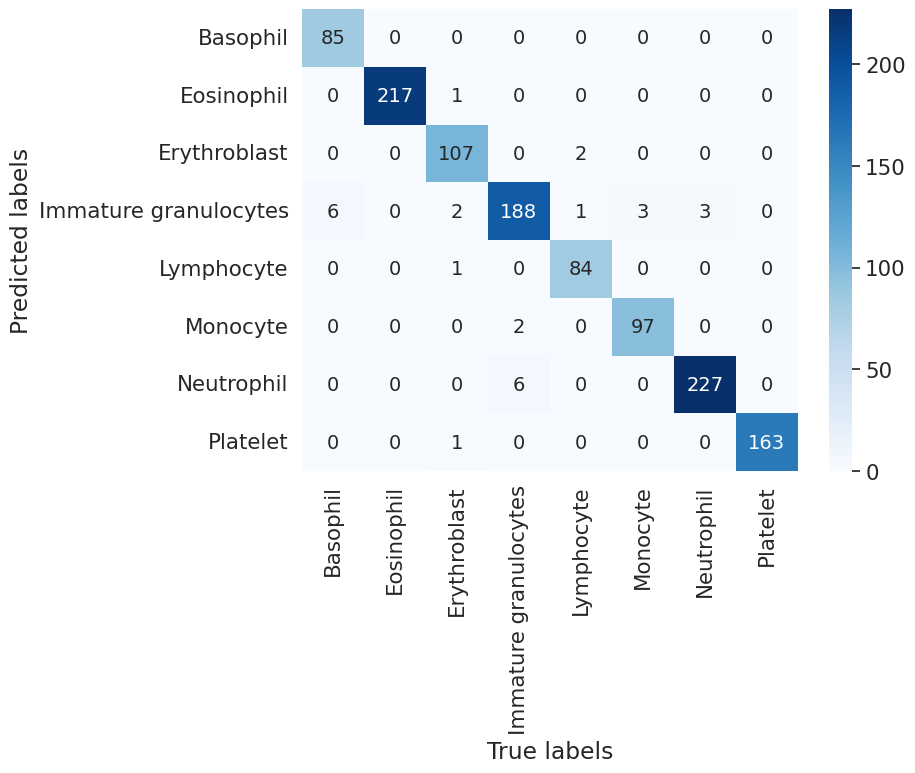

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the saved model
model = tfk.models.load_model('weights.keras')

# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
# argmax fa il contrario di one-hot, ovvero riporta le previsioni nella normale calssificazione (in questo caso da 0 a 7) (bu)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet'], yticklabels=['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet'], cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

del model

### 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}_mobnet_noft.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>